# Building binaries
In this notebook there is the procedure to build binaries starting form the CMDs. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import PolygonSelector, Button
from matplotlib.path import Path
import csv

%matplotlib widget

In [2]:
import sys
import os

# set path to tools folder
module_path = '/Users/giadaaggio/Desktop/Thesis/TOTORO/CODES/tools'
sys.path.append(module_path)

from binaries_utils import BinaryStarUtils
binary = BinaryStarUtils()

In [3]:
colormap = plt.cm.jet

## Cleaning the data
I am going to use only the data whose RADXS in absolute value is lower than 0.4. I won't delete the data, I just put a flag in the dataframe.

In [4]:
# load and clean data
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt'
df = pd.read_csv(input_file, header=None, delim_whitespace=True, 
                   usecols=[0, 1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32], 
                   names=['X','Y','F275W','rad_275','F336W','rad_336','F435W','rad_435','F606W','rad_606','F814W','rad_814','prob_member'], skiprows=55)

df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [5]:
# flag the data that are ok (membership probability and radxs)
# set the conditions
conditions = (
    (df['prob_member'] >= 90) & 
    (np.abs(df['rad_275']) < 0.05) &
    (np.abs(df['rad_336']) < 0.05) &
    (np.abs(df['rad_435']) < 0.05) &
    (np.abs(df['rad_606']) < 0.05) &
    (np.abs(df['rad_814']) < 0.05) 
    )   

# assign the flag 
df['flag'] = np.where(conditions, 1, 0)

In [6]:
# select the data with flag 1 
data = df[df['flag'] == 1]

I load the test stars catalogs, both for the stars in the MS and RGB and for the ones in the HB. Along with them I load the fiducials to make a comparison plot to show that all the stars corresponds in the different filters. 

In [7]:
# load test_hb stars
test_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/test_stars.csv', delim_whitespace=True)
hb_test_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/test_stars_HB.csv', delim_whitespace=True)

In [8]:
test = pd.concat([test_stars, hb_test_stars], ignore_index=True)
test['index'] = test.index

color_test = colors = binary.color_index(test, 'index', colormap)

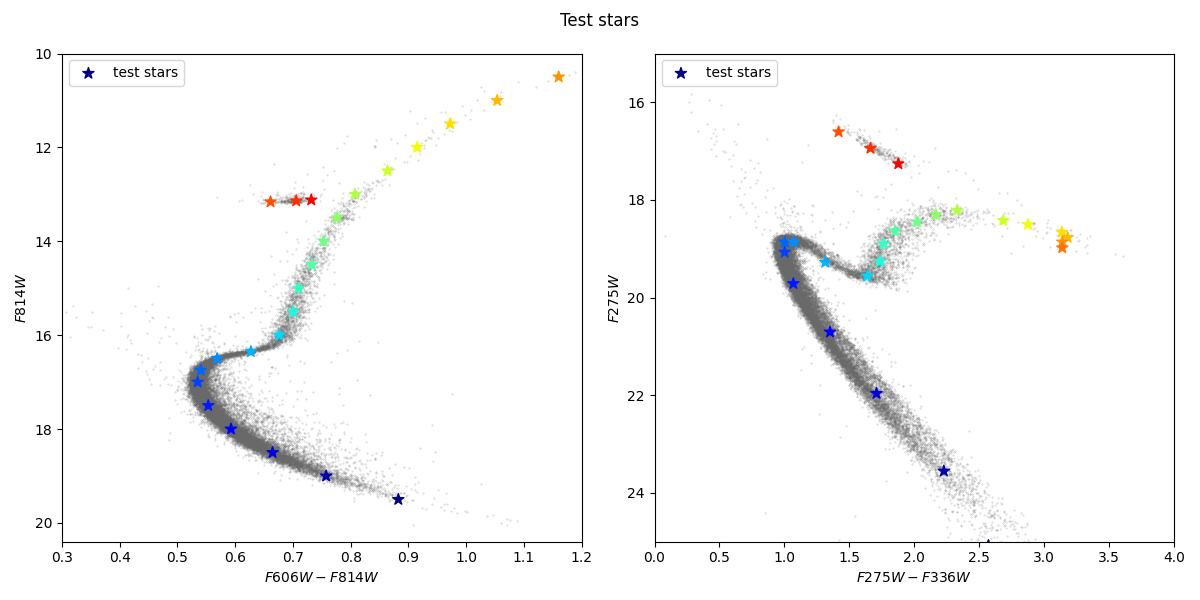

In [9]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(test['F606W']-test['F814W'], test['F814W'], s=70, c=colors, label='test stars', marker='*', zorder=2)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)

plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(test['F275W']-test['F336W'], test['F275W'], s=70, c=colors, label='test stars', marker='*', zorder=2)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.suptitle('Test stars')
plt.tight_layout()
plt.show()

## Binaries with Horizontal Branch stars
To build the binaries I first concatenate the two dataframes, including a column that tells me the original dataframe for each star. 

In [10]:
# concatenate the data, test_hb stars and and horizontal branch stars
test_stars['source'] = 'test_stars'
hb_test_stars['source'] = 'HB_test_stars'

test_hb = pd.concat([test_stars, hb_test_stars], ignore_index=True)
hb_stars_index = test_hb.index[test_hb['source'] == 'HB_test_stars'].tolist()

hb_stars = test_hb.iloc[hb_stars_index]

In [11]:
# binaries in the optical filters
binaries_visible = binary.binary_system_HB(test_hb, hb_stars_index, 'F606W', 'F814W')

colors_vis = binary.color_index(binaries_visible, 'secondary', colormap)

# binaries in the UV filters
binaries_uv = binary.binary_system_HB(test_hb, hb_stars_index, 'F275W', 'F336W')

colors_uv = binary.color_index(binaries_uv, 'secondary', colormap)

#binaries_visible.to_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_HB_vis.csv', index=False, float_format='%.4f', sep=' ')
#binaries_uv.to_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_HB_uv.csv', index=False, float_format='%.4f', sep=' ')


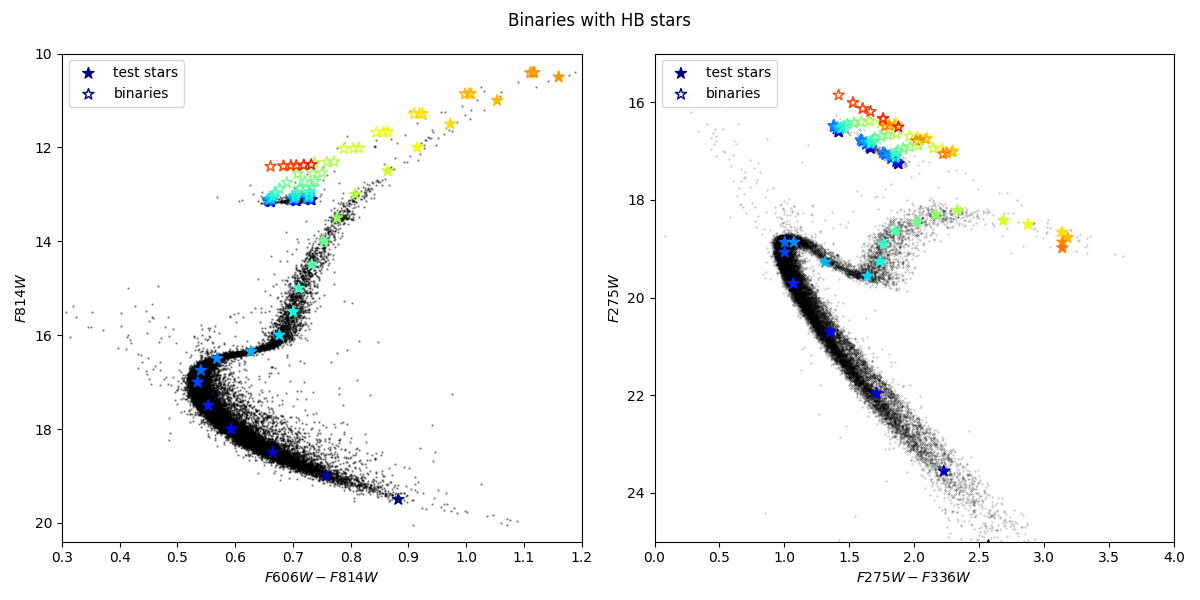

In [12]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
plt.scatter(test_hb['F606W']-test_hb['F814W'], test_hb['F814W'], s=70, c=colors, label='test stars', marker='*', zorder=2)
plt.scatter(binaries_visible['F606W']-binaries_visible['F814W'], binaries_visible['F814W'], s=70, edgecolor=colors_vis, facecolors='none', label='binaries', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)

plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='black', alpha=0.4, zorder=1)
plt.scatter(test_hb['F275W']-test_hb['F336W'], test_hb['F275W'], s=70, c=colors, label='test stars', marker='*', zorder=2)
plt.scatter(binaries_uv['F275W']-binaries_uv['F336W'], binaries_uv['F275W'], s=70, edgecolors=colors_uv, facecolors='none', label='binaries', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.suptitle('Binaries with HB stars')
plt.tight_layout()
plt.show()



## Binaries with RGB stars

In [13]:
test_rgb = pd.concat([test_stars, hb_test_stars], ignore_index=True)

# select stars with indices from 9 to 20
test_rgb_prim = test_rgb.loc[9:20]

primary_indices_rgb = test_rgb_prim.index.tolist()

# build all the binaries iterating over the test_rgb stars
binaries_rgb_vis = binary.binary_system_general(test_rgb, primary_indices_rgb, 'F606W', 'F814W')
colors_rgb_vis = binary.color_index(binaries_rgb_vis, 'secondary', colormap)

binaries_rgb_uv = binary.binary_system_general(test_rgb, primary_indices_rgb, 'F275W', 'F336W')
colors_rgb_uv = binary.color_index(binaries_rgb_uv, 'secondary', colormap)

#binaries_rgb_vis.to_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_RGB_vis.csv', index=False, float_format='%.4f', sep=' ')
#binaries_rgb_uv.to_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_RGB_uv.csv', index=False, float_format='%.4f', sep=' ')


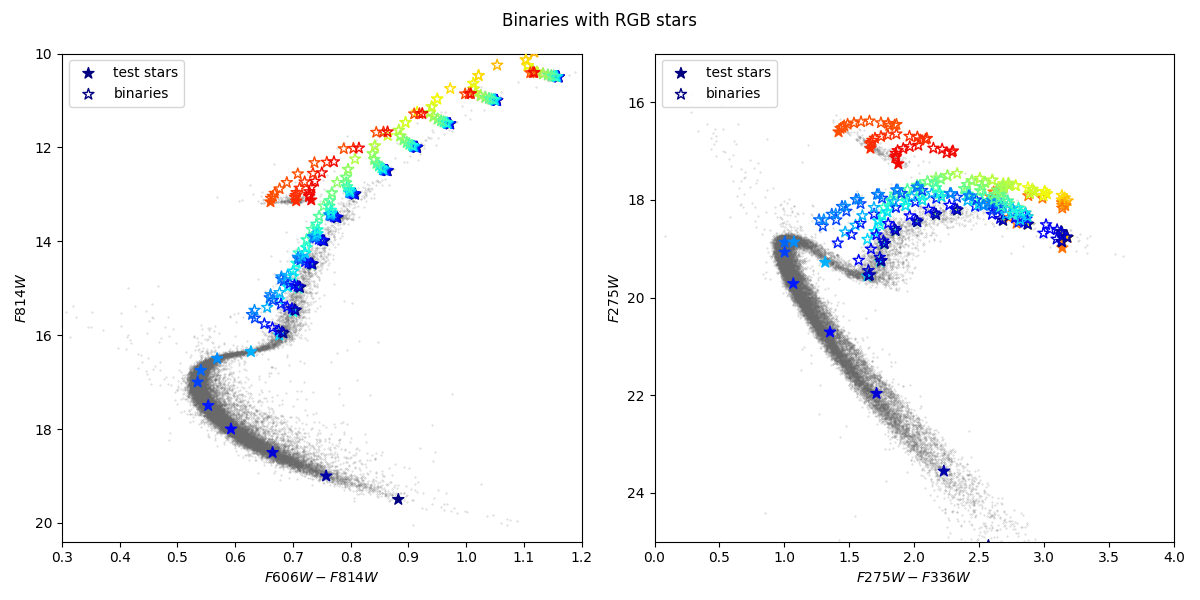

In [14]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(test_rgb['F606W']-test_rgb['F814W'], test_rgb['F814W'], s=70, c=color_test, label='test stars', marker='*', zorder=2)
plt.scatter(binaries_rgb_vis['F606W']-binaries_rgb_vis['F814W'], binaries_rgb_vis['F814W'], s=70, edgecolors=colors_rgb_vis, facecolors='none', label='binaries', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)

plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(test_rgb['F275W']-test_rgb['F336W'], test_rgb['F275W'], s=70, c=color_test, label='test stars', marker='*', zorder=2)
plt.scatter(binaries_rgb_uv['F275W']-binaries_rgb_uv['F336W'], binaries_rgb_uv['F275W'], s=70, edgecolors=colors_rgb_uv, facecolors='none', label='binaries', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.suptitle('Binaries with RGB stars')
plt.tight_layout()
plt.show()

## Binaries with turn-off stars

In [15]:
test_to = pd.concat([test_stars, hb_test_stars], ignore_index=True)
to_star_index = [6]

star_to = test_to.loc[6]

# binaries in the optical filters
bin_to_vis = binary.binary_system_general(test_to, to_star_index, 'F606W', 'F814W')
colors_to = binary.color_index(bin_to_vis, 'secondary', colormap)

# binaries in the UV filters
bin_to_uv = binary.binary_system_general(test_to, to_star_index, 'F275W', 'F336W')
colors_to_uv = binary.color_index(bin_to_uv, 'secondary', colormap)


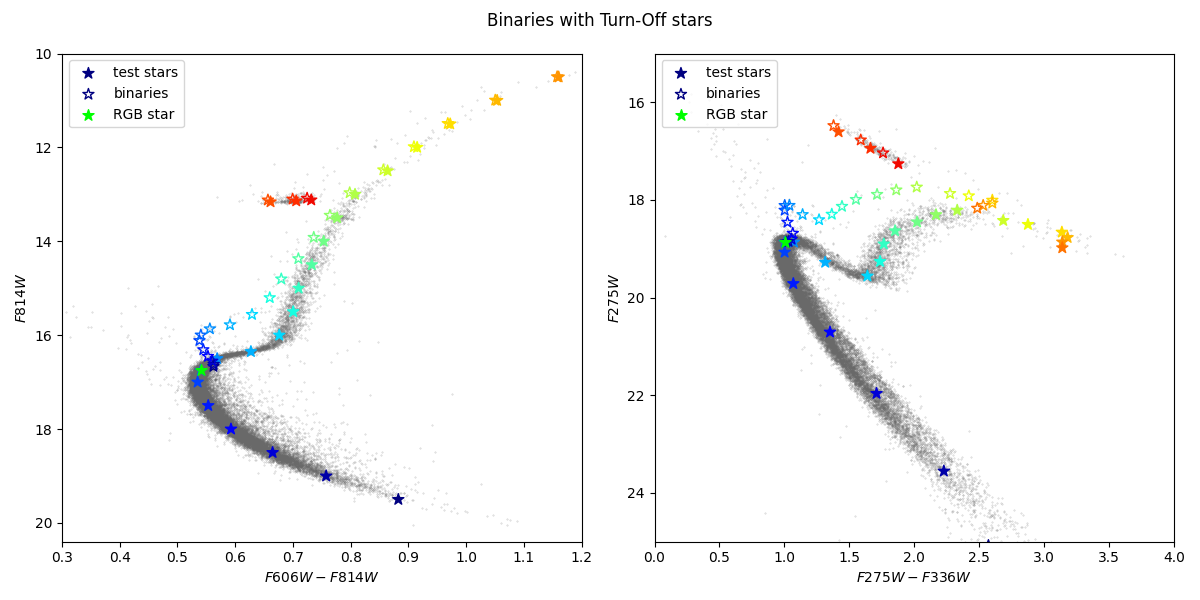

In [16]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(test_to['F606W']-test_to['F814W'], test_to['F814W'], s=70, c=colors_to, label='test stars', marker='*', zorder=2)
plt.scatter(bin_to_vis['F606W']-bin_to_vis['F814W'], bin_to_vis['F814W'], s=70, edgecolors=colors_to, facecolors='none', label='binaries', marker='*', zorder=3)
plt.scatter(star_to['F606W']-star_to['F814W'], star_to['F814W'], s=70, c='lime', label='RGB star', marker='*', zorder=4)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)

plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(test_to['F275W']-test_to['F336W'], test_to['F275W'], s=70, c=colors_to_uv, label='test stars', marker='*', zorder=2)
plt.scatter(bin_to_uv['F275W']-bin_to_uv['F336W'], bin_to_uv['F275W'], s=70, edgecolors=colors_to_uv, facecolors='none', label='binaries', marker='*', zorder=3)
plt.scatter(star_to['F275W']-star_to['F336W'], star_to['F275W'], s=70, c='lime', label='RGB star', marker='*', zorder=4)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.suptitle('Binaries with Turn-Off stars')
plt.tight_layout()
plt.show()